In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA

import animate_helper as ah
reload(ah)

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


<module 'animate_helper' from '/mnt/home/szheng/projects/util_code/animate_helper.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0
print(data_dir_full)
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913
load *SessionPulses.Events.mat failed


/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:144: UserWarning: Some epochs have no duration
  time_support = IntervalSet(start=t[0], end=t[-1], time_units="s")
/mnt/home/szheng/projects/pynapple/pynapple/core/time_series.py:154: RuntimeWarning: divide by zero encountered in double_scalars
  self.rate = len(t) / self.time_support.tot_length("s")


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/spk_beh_df.p saved!


In [3]:
reload(pf)
reload(pa)
cell_cols = cell_cols_d['pyr']
speed_key = 'speed_kalman'
fr_map_d,_,_ = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols_d['pyr'],speed_thresh=1,bin_size=2.2,smth_in_bin=2.5,speed_key=speed_key)
fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=1.,order=['smooth','divide'],speed_key=speed_key)
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_trial_df_d=pd.concat({k:pf.fr_map_trial_to_df(fr_map_trial_d[k],cell_cols) for k in fr_map_dict.keys()},axis=0)


cant format into a dataframe
cant format into a dataframe


In [4]:
import pca_analysis as pcaa
# preprocessing
task_ind,tt_ind = 0,0
fr_map_trial = fr_map_trial_d[task_ind,tt_ind]
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

In [11]:
import vbpca
from scipy.spatial.distance import pdist, squareform


In [12]:
n_fac = 3
ww_l_init, r2_init, l_tot_init, lrecon_init, l_smth_init =vbpca.init(X_l,n_fac=n_fac,lam=0.1,pos_mask=None)

In [13]:
%%time
n_pos = ww_l_init.shape[0]
ww_l_reshape=ww_l_init.reshape(n_pos,-1)
ww_dist_init = pdist(ww_l_reshape,'euclidean')
ww_dist_init=squareform(ww_dist_init)

CPU times: user 684 ms, sys: 66.4 ms, total: 750 ms
Wall time: 860 ms


In [14]:
reload(vbpca)
w_l_init = vbpca.get_w_from_ww_local(ww_l_init,svd_win = 0, n_fac = n_fac)
h_l_init = pcaa.solve_h_all_pos(X_l,w_l_init)

In [ ]:
n_fac=10
ww_l,training_metrics=fit_vbpca(X_l,n_fac=n_fac,lam=100.,n_iters=3)

ax=training_metrics['loss_reconstruct'].plot(marker='o',alpha=0.5)
ax2=ax.twinx()
training_metrics['loss_smooth'].plot(ax=ax2,marker='o',ms=1,color='C1')


In [368]:
ww_init_dist = squareform(pdist(ww_l_init.reshape(n_pos,-1)))

In [ ]:
x_corr = np.corrcoef(X_l.reshape(n_pos,-1))

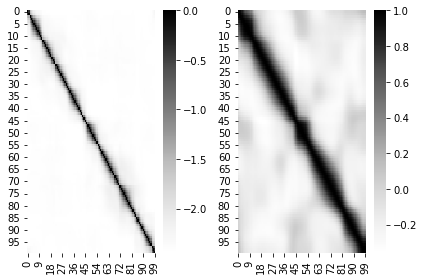

In [378]:
fig,axs=plt.subplots(1,2)
sns.heatmap(-ww_init_dist,cmap='Greys',ax=axs[0])
sns.heatmap(x_corr,cmap='Greys',ax=axs[1])
plt.tight_layout()

(100, 100)

In [ ]:
reload(vbpca)
w_l = vbpca.get_w_from_ww_local(ww_l,svd_win = 0, n_fac = n_fac)
h_l = pcaa.solve_h_all_pos(X_l,w_l)

In [452]:
target=(ww_l_init[5]+ww_l_init[7])/2 
u,s,vh=np.linalg.svd(target)

In [436]:
%%time
ww_l_reshape=ww_l.reshape(n_pos,-1)
ww_dist = pdist(ww_l_reshape,'euclidean')
ww_dist=squareform(ww_dist)

CPU times: user 621 ms, sys: 226 µs, total: 621 ms
Wall time: 620 ms


In [421]:
ww_l[0]

array([[ 1.45212818e-05,  4.73158911e-08, -2.11902157e-05, ...,
         1.30267298e-06, -1.48695125e-04, -2.40341297e-05],
       [ 4.73158911e-08,  5.24876563e-10, -1.20328152e-08, ...,
        -4.48540939e-08, -3.44730134e-07,  4.89668406e-08],
       [-2.11902157e-05, -1.20328152e-08,  4.98179411e-05, ...,
        -2.19481586e-06,  1.88586014e-04,  1.18428016e-04],
       ...,
       [ 1.30267298e-06, -4.48540939e-08, -2.19481586e-06, ...,
         1.18203750e-05, -6.76059582e-05,  2.66907994e-05],
       [-1.48695125e-04, -3.44730134e-07,  1.88586014e-04, ...,
        -6.76059582e-05,  1.82112330e-03, -2.01267184e-05],
       [-2.40341297e-05,  4.89668406e-08,  1.18428016e-04, ...,
         2.66907994e-05, -2.01267184e-05,  4.85154090e-04]])

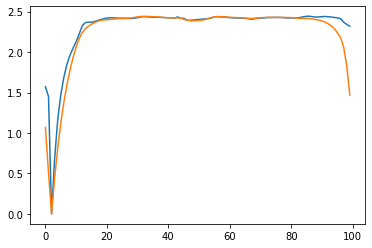

In [438]:
plt.plot(ww_dist_init[2])
plt.plot(ww_dist[2])

<AxesSubplot:>

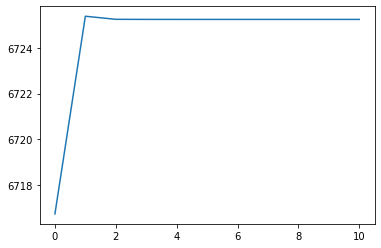

In [347]:
ww_l_init[0]

array([[ 1.71528700e-05,  2.96988634e-07,  8.78390548e-06, ...,
        -1.09573200e-05,  1.42166548e-04,  5.08602336e-07],
       [ 2.96988634e-07,  5.88012095e-09,  2.78258028e-08, ...,
        -2.03736722e-07,  5.80552015e-07, -6.49579080e-07],
       [ 8.78390548e-06,  2.78258028e-08,  2.54299628e-05, ...,
        -3.43234068e-06,  3.97533058e-04,  1.11365474e-04],
       ...,
       [-1.09573200e-05, -2.03736722e-07, -3.43234068e-06, ...,
         1.08586652e-05, -2.13747866e-04,  7.26832476e-06],
       [ 1.42166548e-04,  5.80552015e-07,  3.97533058e-04, ...,
        -2.13747866e-04,  1.29791615e-02,  1.89926541e-03],
       [ 5.08602336e-07, -6.49579080e-07,  1.11365474e-04, ...,
         7.26832476e-06,  1.89926541e-03,  5.94099926e-04]])

In [360]:
i=1
j=8
angles=scipy.linalg.subspace_angles(ww_l_init[i],ww_l_init[j])
np.sqrt(np.sum(angles**2))

2.186743715387215

In [348]:
ww_l_init[1]

array([[ 6.34831879e-06,  2.05706956e-07, -3.12494541e-06, ...,
        -8.33067242e-06, -3.96332724e-05, -3.66173656e-05],
       [ 2.05706956e-07,  7.20241487e-09, -9.63470553e-08, ...,
        -2.22560814e-07, -3.03239219e-06, -1.13372689e-06],
       [-3.12494541e-06, -9.63470553e-08,  3.51010535e-05, ...,
        -4.02637699e-06,  3.71023623e-04,  1.58736853e-04],
       ...,
       [-8.33067242e-06, -2.22560814e-07, -4.02637699e-06, ...,
         1.73004982e-05, -1.96151348e-04,  1.68966281e-05],
       [-3.96332724e-05, -3.03239219e-06,  3.71023623e-04, ...,
        -1.96151348e-04,  9.96984464e-03,  1.59421637e-03],
       [-3.66173656e-05, -1.13372689e-06,  1.58736853e-04, ...,
         1.68966281e-05,  1.59421637e-03,  8.03080484e-04]])

In [251]:
ww_l_concat = np.concatenate(list(ww_l),axis=1)

In [346]:
ww_l_init[]

(100, 422, 422)

In [ ]:
ww_l_concat

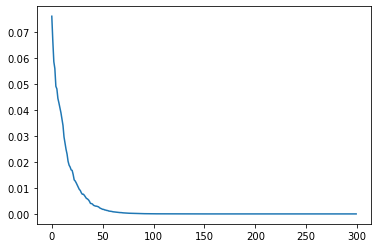

In [264]:
plt.plot(trun_svd.explained_variance_ratio_)

In [283]:
w_l = trun_svd.components_[:n_fac].reshape(n_fac,n_pos,-1).swapaxes(0,1).swapaxes(1,2)

In [13]:
def get_w_from_ww(ww_l,n_fac=3):
    n_pos = ww_l.shape[0]
    ww_l_concat = np.concatenate(list(ww_l),axis=1)
    trun_svd = sklearn.decomposition.TruncatedSVD(n_components=n_fac*n_pos).fit(ww_l_concat)
    w_l = trun_svd.components_[:n_fac].reshape(n_fac,n_pos,-1).swapaxes(0,1).swapaxes(1,2)
    w_ortho_l=[]
    for w in w_l:
        w_,_=np.linalg.qr(w)
        w_ortho_l.append(w_)
    w_ortho_l = np.array(w_ortho_l)
    return w_ortho_l
    

In [326]:
w_ortho_l=[]
for w in w_l:
    w_,_=np.linalg.qr(w)
    w_ortho_l.append(w_)
w_ortho_l = np.array(w_ortho_l)

In [327]:
sim_l=np.einsum('pnf,pnf->pf',w_ortho_l[1:],w_ortho_l[:-1])

In [334]:
sim_l

array([[ 0.97122057,  0.97244932,  0.97646985],
       [-0.62522427,  0.74127021, -0.1891341 ],
       [ 0.97031035, -0.93436552,  0.96672527],
       [ 0.98409077,  0.96490955,  0.96825989],
       [ 0.99266219,  0.98508951,  0.9702847 ],
       [ 0.99652329,  0.99038188,  0.96781533],
       [ 0.99772003,  0.98950941,  0.96532081],
       [ 0.99719772,  0.98548043,  0.96798037],
       [ 0.99226277, -0.97787276,  0.97122356],
       [ 0.97407774,  0.9684216 ,  0.96535973],
       [ 0.93916889,  0.9655512 ,  0.93220295],
       [ 0.85407849,  0.8713955 ,  0.47669849],
       [ 0.96223485,  0.96956343,  0.9803294 ],
       [ 0.98094433,  0.96567125,  0.95925705],
       [ 0.98483168,  0.95941233, -0.92301701],
       [ 0.98242292,  0.97323   ,  0.94935884],
       [ 0.98234329,  0.97934905,  0.96810238],
       [ 0.98315776,  0.98039473,  0.96789358],
       [ 0.98257127,  0.97198788,  0.81847236],
       [ 0.98000169,  0.98083119,  0.92361517],
       [ 0.97807391,  0.98130719,  0.981

# sim data

In [7]:
import pca_analysis as pcaa

task_ind,tt_ind = 0,1
fr_map_trial_original=fr_map_trial_d[task_ind,tt_ind]
fr_map_trial_mean = fr_map_trial_original.mean(axis=(-1))
fr_map_trial_sim = fr_map_trial_mean[:,:,None] * (1+np.arange(fr_map_trial_original.shape[-1])) / (fr_map_trial_original.shape[-1] / 1.5)

task_ind,tt_ind = 0,1
fr_map_trial = fr_map_trial_sim#fr_map_trial_d[task_ind,tt_ind]#fr_map_trial_all#
reload(pcaa)
fr_map_trial_centered_normed_df,fr_map_trial_centered_normed = pcaa.preprocess_fr_map_trial(fr_map_trial,cell_cols)
X_l=pcaa.prep_X_l(fr_map_trial_centered_normed)

# fr_map_trial_sim_centered=fr_map_trial_sim - fr_map_trial_sim.mean(axis=-1,keepdims=True)
# X_l = fr_map_trial_sim_centered.swapaxes(0,1)

100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


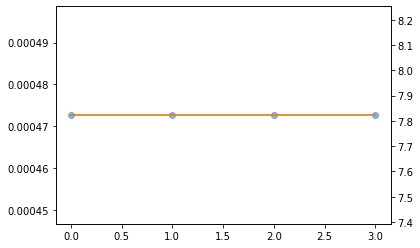

In [347]:
n_fac=1
ww_l,training_metrics=fit_vbpca(X_l,n_fac=n_fac,lam=1.,n_iters=3)

ax=training_metrics['loss_reconstruct'].plot(marker='o',alpha=0.5)
ax2=ax.twinx()
training_metrics['loss_smooth'].plot(ax=ax2,marker='o',ms=1,color='C1')
w_l = get_w_from_ww(ww_l)
h_l = pcaa.solve_h_all_pos(X_l,w_l)

In [348]:
def concat_svd_qr(ww_l,n_fac=1):
    ww_l_sub_concat = np.concatenate(ww_l,axis=1)
    trunsvd = sklearn.decomposition.TruncatedSVD(n_components=n_fac)
    trunsvd.fit(ww_l_sub_concat)
    w = trunsvd.transform(ww_l_sub_concat)
    w,_ = np.linalg.qr(w)
    return w

In [338]:
w_l[0]

(100, 422, 1)

In [339]:
def align_two_w(w_prev,w_next):
    inner_prod=np.einsum('nf,nf->f',w_prev,w_next)
    w_next[:,inner_prod<0] = w_next[:,inner_prod<0] * -1
    return w_next
    

In [353]:
%%time
svd_win = 0
n_fac = 1
n_pos = ww_l.shape[0]
w_l = []
for p in range(n_pos):
    inds=np.arange((p-svd_win),p + svd_win+1)
    inds = inds%n_pos
    ww_l_sub_concat = np.concatenate(ww_l[inds],axis=1)
#     u,s,vh=np.linalg.svd(ww_l_sub_concat)
#     w = u[:,:n_fac]
    trunsvd = sklearn.decomposition.TruncatedSVD(n_components=n_fac)
    trunsvd.fit(ww_l_sub_concat)
    w = trunsvd.transform(ww_l_sub_concat)
    w,_ = np.linalg.qr(w)
    if p > 0:
        w_prev = w_l[(p-1)%n_pos]
        w = align_two_w(w_prev,w)
    w_l.append(w)


w_l = np.array(w_l)
h_l = pcaa.solve_h_all_pos(X_l,w_l)

CPU times: user 2.7 s, sys: 1.61 s, total: 4.3 s
Wall time: 1.08 s


In [354]:
w_dist=squareform(pdist(w_l[:,:,0]))
x_dist=squareform(pdist(X_l[:,:,0]))
x_corr = np.corrcoef(X_l[:,:,0])
w_corr = np.corrcoef(w_l[:,:,0])

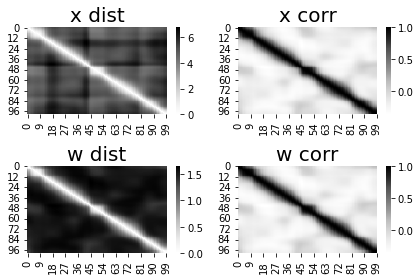

In [355]:
fig,axs=plt.subplots(2,2)
sns.heatmap(x_dist,cmap='Greys',ax=axs[0,0])
axs[0,0].set_title('x dist')
sns.heatmap(x_corr,cmap='Greys',ax=axs[0,1])
axs[0,1].set_title('x corr')
sns.heatmap(w_dist,cmap='Greys',ax=axs[1,0])
axs[1,0].set_title('w dist')
sns.heatmap(w_corr,cmap='Greys',ax=axs[1,1])
axs[1,1].set_title('w corr')
plt.tight_layout()

In [333]:
# ww_sub_concat=np.concatenate(ww_l[16:19],axis=1)
w_ = concat_svd_qr(ww_l[16:19],n_fac=1)

In [336]:
w_[:,0]

array([0.00000000e+000, 0.00000000e+000, 8.54397868e-004, 3.13630559e-001,
       5.92125049e-002, 4.25818998e-002, 2.66655434e-032, 5.70986349e-002,
       3.31441614e-002, 1.14273733e-002, 4.16915866e-002, 1.59123047e-001,
       4.47732359e-002, 4.81923185e-003, 1.58971901e-002, 8.68638100e-003,
       1.48587044e-003, 5.14292670e-002, 4.04635949e-002, 2.00892076e-001,
       1.12877246e-002, 1.43361857e-001, 2.73964255e-002, 1.47516984e-001,
       6.67767009e-002, 5.88203077e-004, 1.01319930e-001, 1.45870106e-002,
       2.02806333e-002, 3.45412512e-002, 1.49811152e-001, 6.52955991e-002,
       5.68900417e-002, 2.44690359e-002, 8.81659019e-002, 4.07335329e-002,
       8.98529628e-002, 2.60871907e-002, 2.79573668e-002, 2.42915349e-001,
       2.85083264e-002, 1.26101163e-002, 1.13854729e-002, 6.58445278e-002,
       2.21109398e-001, 4.23984795e-002, 4.52999434e-002, 1.34964803e-002,
       4.18455832e-002, 1.11311368e-001, 4.26178414e-002, 7.73479295e-003,
       1.03111319e-002, 4

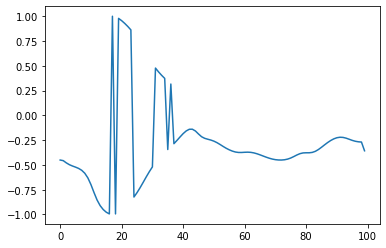

In [329]:
plt.plot(w_corr[17])

<AxesSubplot:>

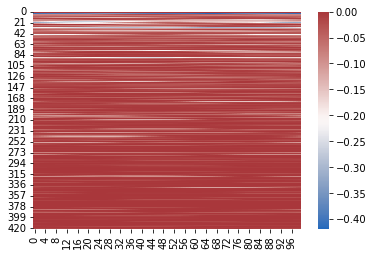

In [276]:
%matplotlib inline
sns.heatmap(w_l[:,:,0].T,cmap='vlag')

<AxesSubplot:>

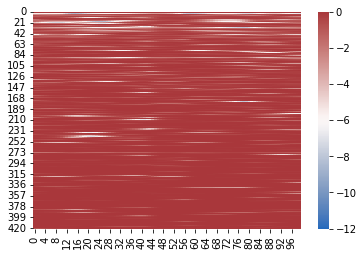

In [265]:
sns.heatmap(X_l[:,:,10].T,cmap='vlag')

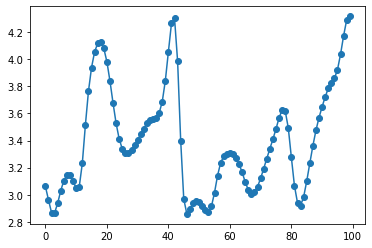

In [352]:
plt.plot(h_l[:,0,:][:,0],marker='o')